# Aspect aware clustering demo

Demonstrate and test functions defined in 'aa_cluster.py'

In [13]:
import regex, os, sys
from pathlib import Path
import numpy as np
import pandas as pd
import pickle
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import HTML
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegressionCV

sys.path.append('../')
from ThoughtGraph import ThoughtGraph #, tg_utils
import importlib
from aa_cluster import *
import aa_cluster           # needed for reloading the module while debugging
from cluster_evaluation import *
from text_patterns import patterns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

N_CLUSTERS = 200
SEED = 0

DATA_DIR = '../dolly_data/'
DATA_FILE = "dolly_pos_clusters_5gram.parquet"
MODELS_FILE = "positive_and_negative_reweighting_models.pickle"

FP_TYPE = 'float32'
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
framework_flags = ['identify', 'how_does', 'why_is', 'what is', 'extract',
       'of_the_following', 'given_text', 'alternatives', 'output_format']

flag_category_map = {k: 'framework' if k in framework_flags else 'domain' for k in patterns.keys()}
flag_category_map

{'cars': 'domain',
 'animals': 'domain',
 'food': 'domain',
 'programming_language': 'domain',
 'sports': 'domain',
 'science': 'domain',
 'science_fiction': 'domain',
 'data_science': 'domain',
 'information_technology': 'domain',
 'books': 'domain',
 'identify': 'framework',
 'how_does': 'framework',
 'why_is': 'framework',
 'what is': 'framework',
 'extract': 'framework',
 'of_the_following': 'framework',
 'given_text': 'framework',
 'alternatives': 'framework',
 'output_format': 'framework'}

In [11]:
instruction_data = pd.read_parquet(Path(DATA_DIR) / DATA_FILE)[['instruction', 'category', 'instruction_vector']] # 'pos_tfidf_PCs'
instruction_data['instruction_vector'] = [v.astype(FP_TYPE) for v in instruction_data['instruction_vector']]
instruction_data['unit_vector'] = to_unit_vectors(instruction_data['instruction_vector'])

# instruction_data['unit_vector'][0].dtype  # 'float32'

In [17]:
dendro = get_cluster_dendrogram(instruction_data['unit_vector'])
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pattern_flags = find_pattern_flags_in_text(instruction_data['instruction'], patterns)

if os.path.exists(MODELS_FILE):
    my_models = pickle.load(open(MODELS_FILE, "rb"))
else:
    my_models = train_pattern_models(instruction_data['instruction_vector'], pattern_flags, verbose=True)
    pickle.dump(my_models, open(MODELS_FILE, "wb"))
    


Fitting model for 'cars'
Fitting model for 'animals'
Fitting model for 'food'
Fitting model for 'programming_language'
Fitting model for 'sports'
Fitting model for 'science'
Fitting model for 'science_fiction'
Fitting model for 'data_science'
Fitting model for 'information_technology'
Fitting model for 'books'
Fitting model for 'identify'
Fitting model for 'how_does'
Fitting model for 'why_is'
Fitting model for 'what is'
Fitting model for 'extract'
Fitting model for 'of_the_following'
Fitting model for 'given_text'
Fitting model for 'alternatives'
Fitting model for 'output_format'


In [19]:
# importlib.reload(aa_cluster)
pattern_scores = get_model_scores_for_vectors(instruction_data['instruction_vector'], my_models)

mean_xval_auc = get_model_mean_xval_auc(my_models)

cluster_assignment_df = get_cluster_assignments(dendro)

cluster_performance_df = get_cluster_performance_df(cluster_assignment_df, pattern_flags, flag_category_map)
                                           
cluster_performance_df

TypeError: Linkage matrix 'Z' must contain doubles.

In [ ]:
# importlib.reload(aa_cluster)  # call this to debug aa_cluster
cluster_performance_df = get_cluster_performance_df(cluster_assignment_df, pattern_flags, flag_category_map)
cluster_performance_df

,num_clusters,mean_entropy,mean_purity,delta_entropy,roc,auc,ref_auc,flag,cluster_col,flag_category
0,2,0.145423,0.966330,0.077903,fpr tpr threshold 0 0.000000 ...,0.576277,0.576277,cars,A,domain
1,4,0.126685,0.971654,0.116194,fpr tpr threshold 0 0.000000 ...,0.598428,0.598428,cars,B,domain
2,8,0.125725,0.971096,0.135539,fpr tpr threshold 0 0.000000 ...,0.656383,0.656383,cars,C,domain
3,16,0.138608,0.962432,0.146612,fpr tpr threshold 0 0.000000...,0.740410,0.740410,cars,D,domain
4,32,0.121326,0.969315,0.150411,fpr tpr threshold 0 0.000000...,0.779616,0.779616,cars,E,domain
...,...,...,...,...,...,...,...,...,...,...
147,16,0.080791,0.962132,0.100131,fpr tpr threshold 0 0.000000...,0.886755,0.886755,output_format,D,framework
148,32,0.059065,0.977764,0.102027,fpr tpr threshold 0 0.000000...,0.895834,0.895834,output_format,E,framework
149,64,0.050857,0.986641,0.103064,fpr tpr threshold 0 0.000000...,0.919168,0.919168,output_format,F,framework
150,128,0.044666,0.988322,0.103500,fpr tpr threshold 0 0.0000...,0.943158,0.943158,output_format,G,framework


In [ ]:
importlib.reload(aa_cluster)
plot_auc_vs_delta_entropy(cluster_performance_df, category='framework')

/mnt/512G_hd/repos/instruction_tuning/aa_cluster.py:257: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  cpdf.log_delta_entropy  = np.log(cpdf.delta_entropy)


ValueError: Could not interpret value `log_delta_entropy` for parameter `y`

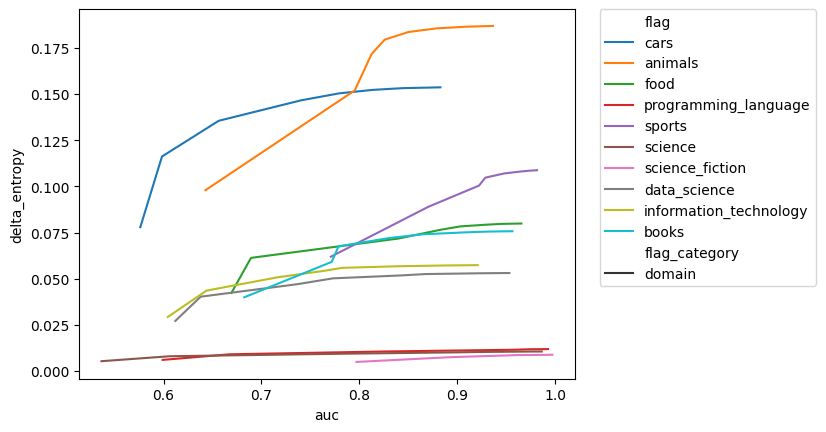

In [ ]:
plot_auc_vs_delta_entropy(cluster_performance_df, category='domain')

In [ ]:
# In case you need the details on individual clusters, or if you want the table to plot an ROC curve:
# cluster_stats = get_cluster_stats(cluster_assignment_df['D'], pattern_flags['cars'])
# cluster_roc = get_cluster_roc(cluster_assignment_df['D'], pattern_flags['animals'])
# cluster_stats

,p,n,pos,neg,entropy,purity
cluster,,,,,,
1,0.017870,1399,25,1374,0.089629,0.982130
2,0.020595,437,9,428,0.100346,0.979405
3,0.045151,598,27,571,0.183981,0.954849
4,0.011436,787,9,778,0.062500,0.988564
5,0.016756,1313,22,1291,0.085128,0.983244
6,0.029994,1567,47,1520,0.134720,0.970006
7,0.761905,231,176,55,0.548874,0.761905
8,0.031879,596,19,577,0.141215,0.968121
9,0.032804,945,31,914,0.144359,0.967196


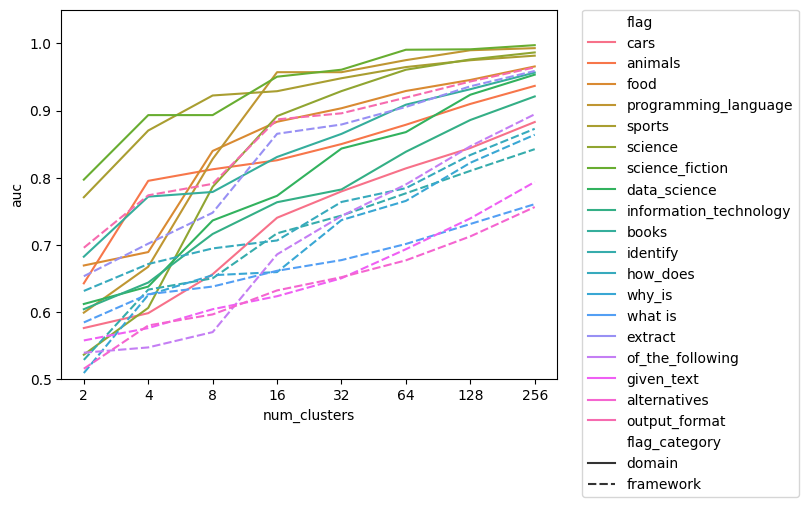

In [ ]:
plot_cluster_performance(cluster_performance_df, metric='auc')

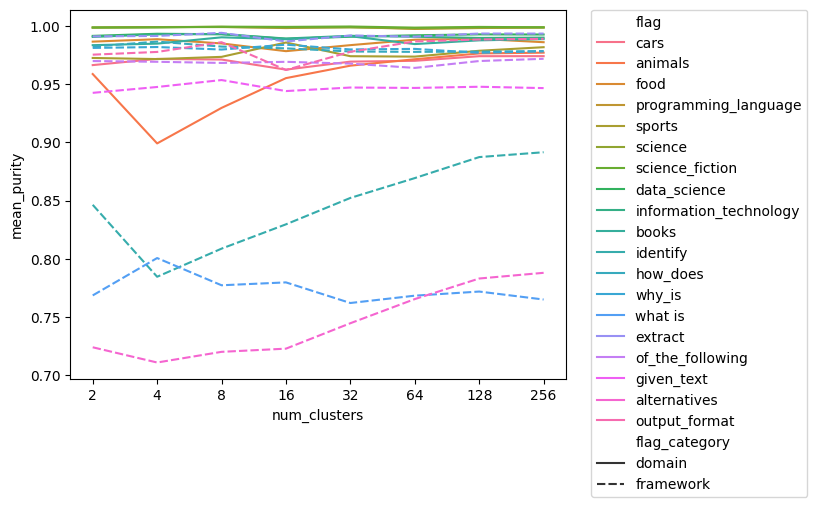

In [ ]:
plot_cluster_performance(cluster_performance_df, metric='mean_purity')

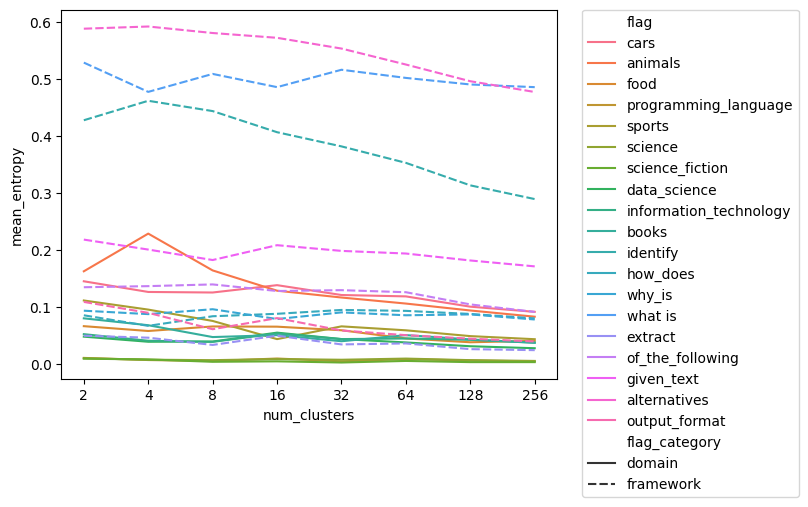

In [ ]:
plot_cluster_performance(cluster_performance_df, metric='mean_entropy')

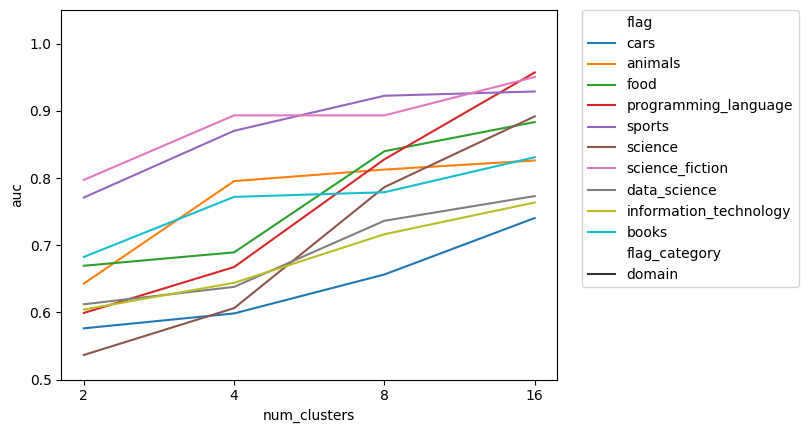

In [ ]:
abcd = cluster_performance_df[ [cc in ['A', 'B', 'C', 'D'] for cc in cluster_performance_df['cluster_col'] ] ]

plot_cluster_performance(abcd[ [f not in framework_flags for f in abcd['flag']] ])

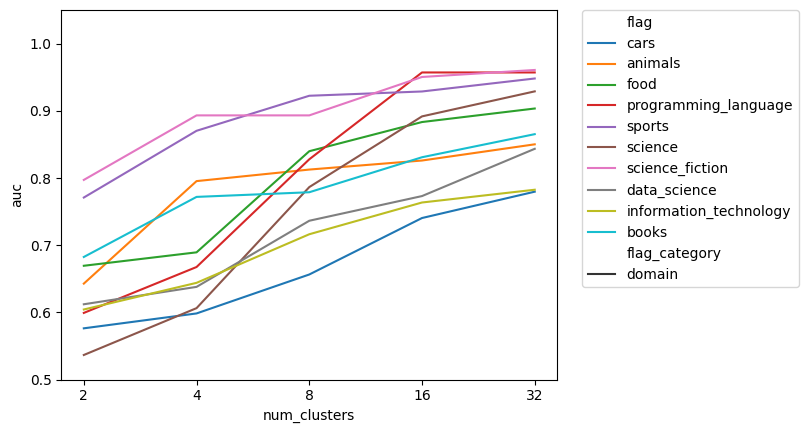

In [ ]:
abcde = cluster_performance_df[ [cc in ['A', 'B', 'C', 'D', 'E'] for cc in cluster_performance_df['cluster_col'] ] ]
abcde
selected = abcde[ [f not in framework_flags for f in abcde['flag']] ].reset_index(drop=True) # added drop_index to function; why do we need it?
plot_cluster_performance( selected )

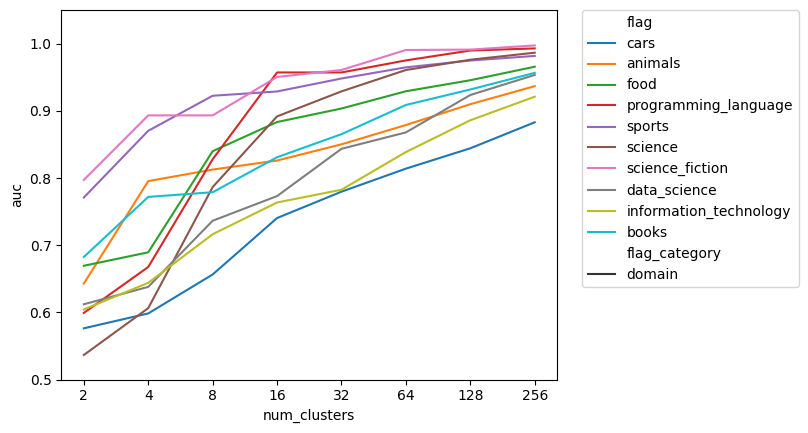

In [ ]:
plot_cluster_performance(cluster_performance_df[ [f not in framework_flags for f in cluster_performance_df['flag']] ])

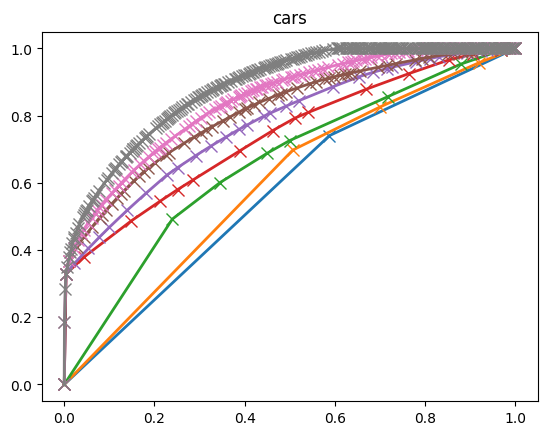

8 ['0.576', '0.598', '0.656', '0.740', '0.780', '0.814', '0.844', '0.883']


In [ ]:
plot_aspect_roc_curves('cars', cluster_performance_df)

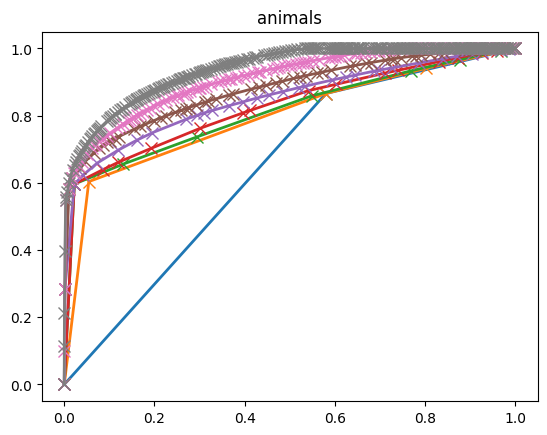

8 ['0.643', '0.795', '0.813', '0.826', '0.850', '0.879', '0.910', '0.937']


In [ ]:
plot_aspect_roc_curves('animals', cluster_performance_df)

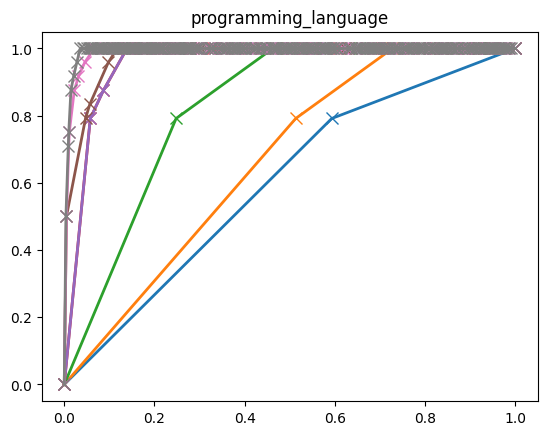

8 ['0.599', '0.668', '0.828', '0.957', '0.957', '0.975', '0.990', '0.993']


In [ ]:
plot_aspect_roc_curves('programming_language', cluster_performance_df)

# Where is the red curve?

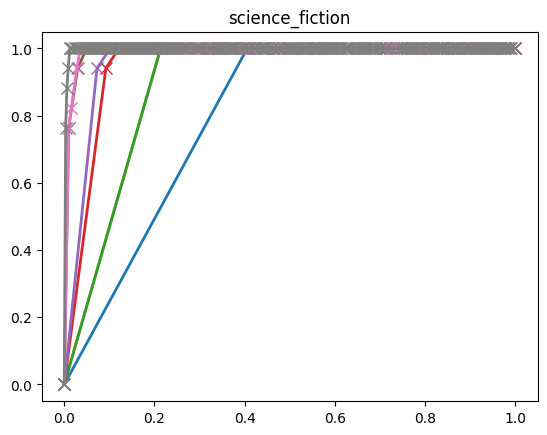

8 ['0.797', '0.893', '0.893', '0.950', '0.961', '0.990', '0.991', '0.997']


In [ ]:
plot_aspect_roc_curves('science_fiction', cluster_performance_df) # science

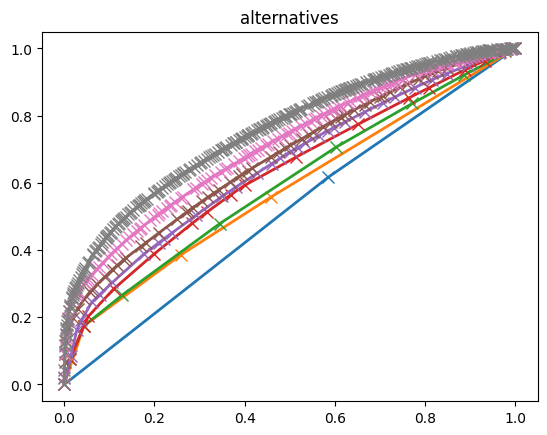

8 ['0.516', '0.580', '0.597', '0.632', '0.652', '0.677', '0.713', '0.756']


In [ ]:
plot_aspect_roc_curves('alternatives', cluster_performance_df)

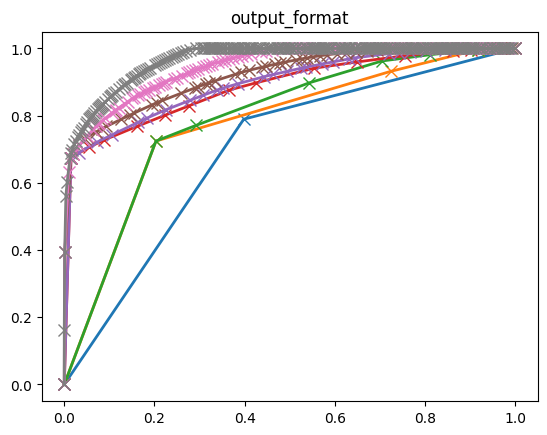

8 ['0.696', '0.774', '0.791', '0.887', '0.896', '0.919', '0.943', '0.964']


In [ ]:
plot_aspect_roc_curves('output_format', cluster_performance_df)

# Re-weight embeddings

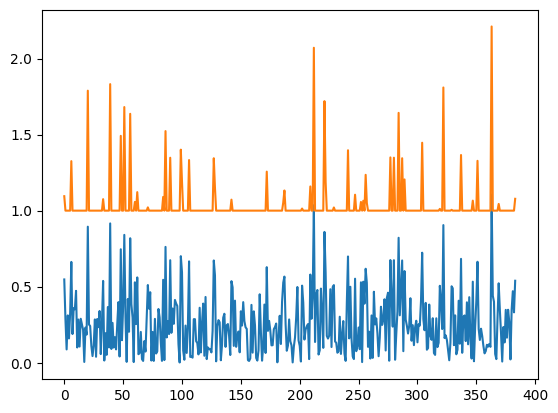

In [ ]:
mean_framework_coefs = np.mean([ my_models[flag].coef_[0] for flag in framework_flags ], axis=0)
plt.plot(np.abs(mean_framework_coefs))

adjustment_vector = [ 1 if x<1 else x for x in 2*np.abs(mean_framework_coefs) ]

plt.plot(adjustment_vector)

In [ ]:
# my_modifier = my_models['animals'].coef_.astype(FP_TYPE)

# projection = np.array([ get_projection(emb, mean_framework_coefs) for emb in instruction_data['unit_vector'] ])
# projection.shape  # (15011, 384)

In [ ]:
# def plot_cluster_aucs(my_cluster_aucs, title='', file=''):
#     """
#     Plot cluster AUC vs. cluster size, from the data returned by 'extract_cluster_aucs'

#     usage:
#         cluster_rocs = get_cluster_performance_df(cluster_assignment_df, pattern_flags, flag_category_map)
#         plot_cluster_aucs(cluster_aucs)

#     """
#     ax = sns.lineplot(x='num_clusters', y='auc', data=my_cluster_aucs, hue='flag')
#     plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
#     plt.title(title)
#     plt.ylim(0.5, 1.05)
#     ax.set_xscale('log')
#     if file != '':
#         plt.savefig(file)

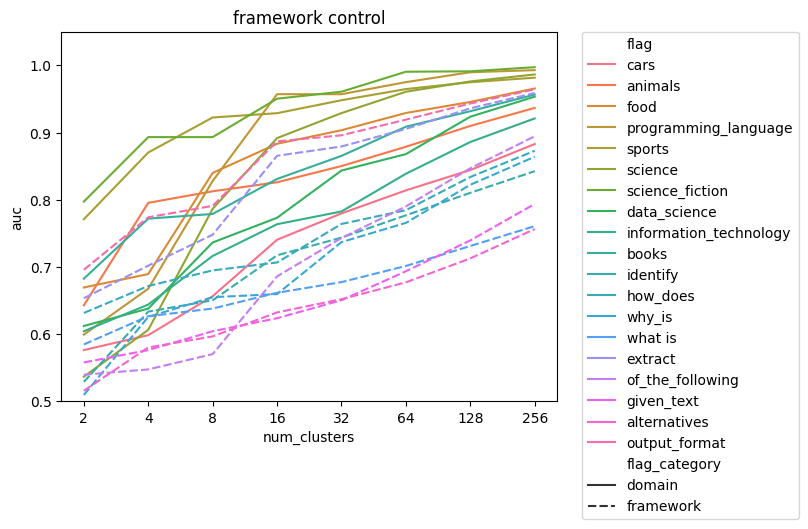

In [ ]:
ctl_dendro = get_cluster_dendrogram(instruction_data['unit_vector'])

ctl_cluster_assignment_df = get_cluster_assignments(ctl_dendro, num_slices=8)

ctl_cluster_performance_df = get_cluster_performance_df(ctl_cluster_assignment_df, pattern_flags, flag_category_map)

plot_cluster_performance(ctl_cluster_performance_df, title="framework control", file='auc_framework_control.png')

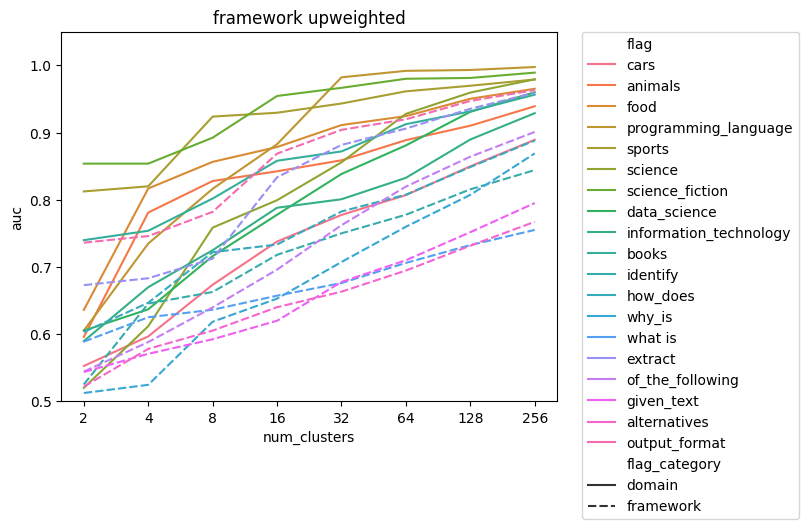

In [ ]:
# alpha = 1
# upweighted_embedding = [emb + alpha * prj for emb, prj in zip(instruction_data['unit_vector'], projection)]

upweighted_embedding = [emb * adjustment_vector for emb in instruction_data['unit_vector'] ]

uw_dendro = get_cluster_dendrogram(upweighted_embedding)

uw_cluster_assignment_df = get_cluster_assignments(uw_dendro, num_slices=8)

uw_cluster_performance_df = get_cluster_performance_df(uw_cluster_assignment_df, pattern_flags, flag_category_map)

plot_cluster_performance(uw_cluster_performance_df, title="framework upweighted", file='auc_framework_upweighted_adj.png')

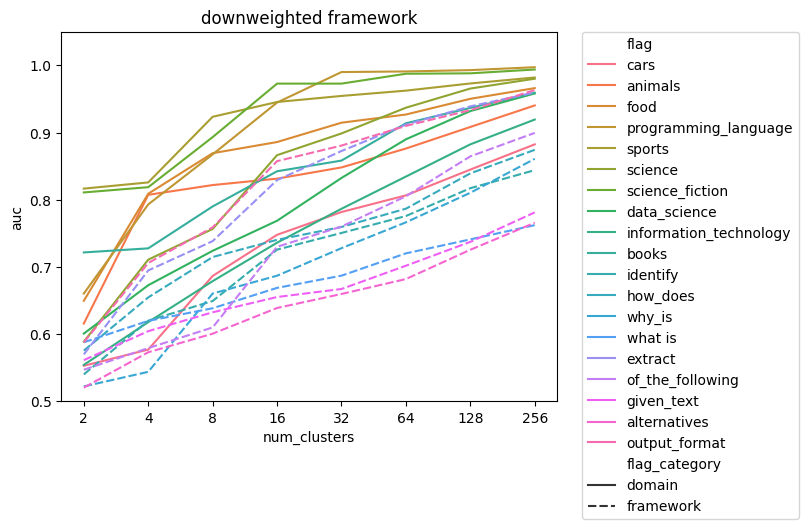

In [ ]:
# alpha = -1

downweighted_embedding = [emb / adjustment_vector for emb in instruction_data['unit_vector']]
                        
dw_dendro = get_cluster_dendrogram(downweighted_embedding)

dw_cluster_assignment_df = get_cluster_assignments(dw_dendro, num_slices=8)

dw_cluster_performance_df = get_cluster_performance_df(dw_cluster_assignment_df, pattern_flags, flag_category_map)

plot_cluster_performance(dw_cluster_performance_df, title="downweighted framework", file='auc_framework_downweighted_adj_inv.png')

upweighted framework


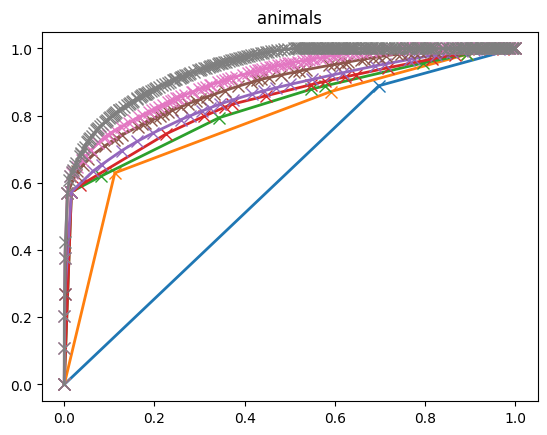

8 ['0.596', '0.781', '0.828', '0.842', '0.859', '0.889', '0.910', '0.939']
control (unweighted)


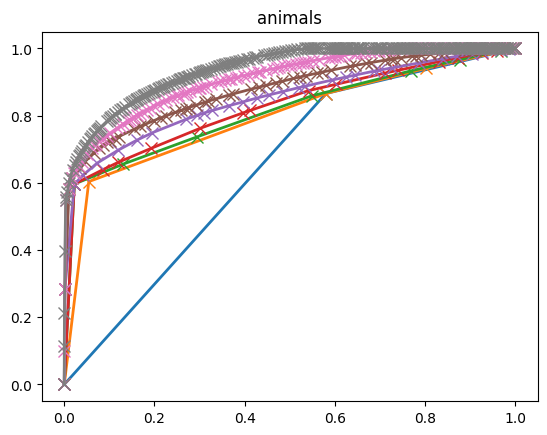

8 ['0.643', '0.795', '0.813', '0.826', '0.850', '0.879', '0.910', '0.937']
downweighted framework


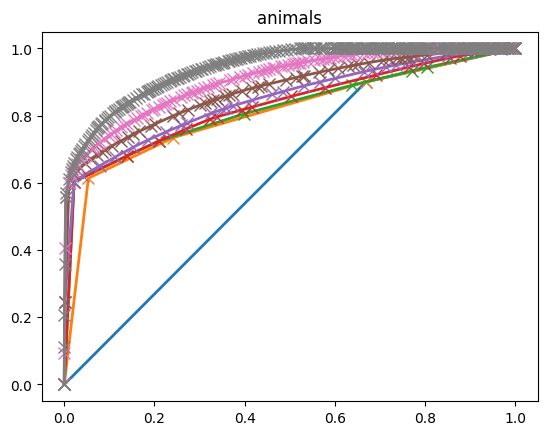

8 ['0.616', '0.807', '0.822', '0.831', '0.848', '0.876', '0.908', '0.940']


In [ ]:
my_topic = 'animals'
print('upweighted framework')
plot_aspect_roc_curves(my_topic, uw_cluster_performance_df)

print('control (unweighted)')
plot_aspect_roc_curves(my_topic, ctl_cluster_performance_df)

print('downweighted framework')
plot_aspect_roc_curves(my_topic, dw_cluster_performance_df)

# In Progress

## Improved strip plots

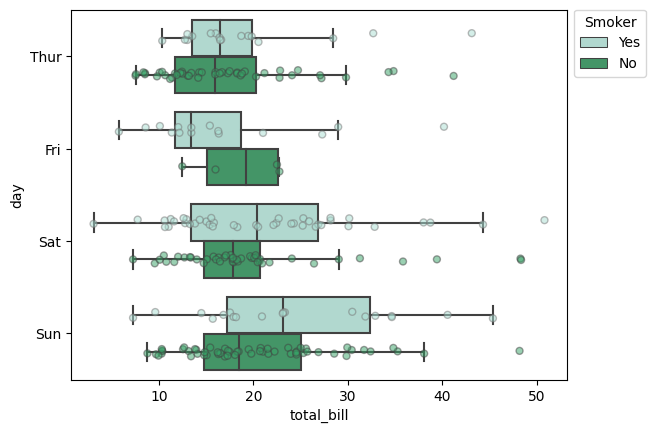

In [ ]:
import seaborn as sns

# load the dataframe
tips = sns.load_dataset('tips')

common_params = {'y': "day", 'x': "total_bill", 'hue': "smoker", 'data': tips, 'palette': "BuGn"}
ax = sns.boxplot(fliersize=0, **common_params)

# add stripplot with dodge=True
sns.stripplot(dodge=True, ax=ax, ec='k', linewidth=1, alpha=0.5, **common_params)

# remove extra legend handles and place legend outside bbox
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2], title='Smoker', bbox_to_anchor=(1, 1.02), loc='upper left')


(-0.05, 1.05)

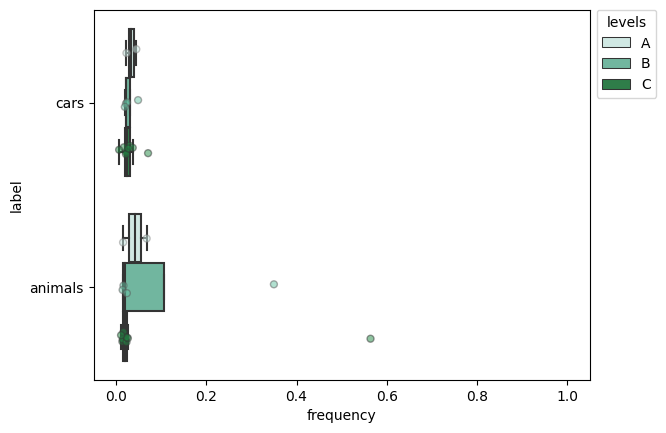

In [ ]:
import seaborn as sns

# # load the dataframe
# tips = sns.load_dataset('tips')

# common_params = {'y': "day", 'x': "total_bill", 'hue': "smoker", 'data': tips, 'palette': "BuGn"}
# ax = sns.boxplot(fliersize=0, **common_params)

# # add stripplot with dodge=True
# sns.stripplot(dodge=True, ax=ax, ec='k', linewidth=1, alpha=0.5, **common_params)

# # remove extra legend handles and place legend outside bbox
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles[:2], labels[:2], title='Smoker', bbox_to_anchor=(1, 1.02), loc='upper left')

clusterings = cluster_assignment_df.reset_index(drop=True)
flags_df = pattern_flags.reset_index(drop=True)

flag_cols = flags_df.columns[0:2]
cluster_cols = clusterings.columns[0:3]
cfdf = clusterings[cluster_cols].join(flags_df[flag_cols])
cfdf_long = pd.melt(cfdf, id_vars=flag_cols, var_name='level', value_name='cluster_id')
cfreqs = cfdf_long.groupby(['level', 'cluster_id']).mean().reset_index()

lff_long = pd.melt(cfreqs, id_vars=['level', 'cluster_id'], var_name='label', value_name='frequency')

lff_long  # level, cluster_id, label, frequency

common_params = {'y': "label", 'x': "frequency", 'hue': "level", 'data': lff_long, 'palette': "BuGn"}
ax = sns.boxplot(fliersize=0, **common_params)  # violinplot? bw=0.1, 

# add stripplot with dodge=True
sns.stripplot(dodge=True, ax=ax, ec='k', linewidth=1, alpha=0.5, **common_params)

# remove extra legend handles and place legend outside bbox
handles, labels = ax.get_legend_handles_labels()

num_levels = len(cluster_cols)
ax.legend(handles[:num_levels], labels[:num_levels], title='levels', bbox_to_anchor=(1, 1.02), loc='upper left')

plt.xlim(-0.05,1.05)
# cfdf_long = cfdf.melt(id_vars=['cars', 'sports'], var_name='variable', value_name='value')
# cfdf_long

#################################################################################################################################
# TO DO: Stack results from clusterings on differently weighted embeddings, then run this plot. Do associated statistical tests.#
#################################################################################################################################

## Upgrading ROC curves

In [ ]:

# Modify `plot_aspect_roc_curves` to use a specified color spectrum. We want to represent multiple sets of ROC curves in the same plot with
# a distinguishable spectrum for each plot.
# Order clusters by p-value from binomial distribution?

reds = hue_spectrum(8, hue=0, saturation=1)
print("reds =", reds)

blues = hue_spectrum(8, hue=2/3, saturation=1)
print("blues =", blues)

reds = <list_reverseiterator object at 0x000002274AA58C10>
blues = <list_reverseiterator object at 0x000002274AA5A7A0>


In [ ]:
# To do:   ???Rank clusters by posterior probability after seeing that many positive and negative cases.
# Or does the binomial distribution give us anything we can use? For each cluster, n = size, p = overall prevalence of positive labels

from scipy.stats import binom

n = 10    # number of trials
p = 0.5  # probability of success in each trial
x = [k for k in range(n+1)] # probability of this many successes or fewer

pdf = pd.DataFrame({'successes': x, 'pmf': binom.pmf(x, n, p), 'cdf': binom.cdf(x, n, p)})
pdf['cdf2'] = np.cumsum(pdf['pmf'])
pdf
# binom.cdf(0, n, p)
# 0.5**8 # 0.00390625

,successes,pmf,cdf,cdf2
0,0,0.000977,0.000977,0.000977
1,1,0.009766,0.010742,0.010742
2,2,0.043945,0.054688,0.054688
3,3,0.117187,0.171875,0.171875
4,4,0.205078,0.376953,0.376953
5,5,0.246094,0.623047,0.623047
6,6,0.205078,0.828125,0.828125
7,7,0.117187,0.945312,0.945312
8,8,0.043945,0.989258,0.989258
9,9,0.009766,0.999023,0.999023


In [ ]:
# text_col = 'instruction'
# for pattern_name in patterns:
#     flag_vector = [bool(regex.search(patterns[pattern_name], sent, regex.IGNORECASE)) for sent in instruction_data[text_col]]
#     instruction_data[f"{pattern_name}_flag"] = flag_vector
#     print(pattern_name, sum(flag_vector))

# class WeightableClustering():
#     """A single text vector can have multiple embeddings, each of which can be used for multiple clusterings."""
#     def __init__(self, text_list):
#         self.text = text_list
#         self.embeddings = {}    # key = name, value=list of embedding vectors
#         self.ClusterTrees = {}  # key = descriptor, value = ClusterTree object

#     def add_embedding(self, embedding_name, embedding_obj):
#         self.embeddings[embedding_name] = embedding_obj

# class ClusterTree():

#     def __init__(self, text_list):
#         self.embedding = []   # embedding vectors
#         self.dendrograms = {}  # key = descriptor, value = ClusterTree object

